In [154]:
import os
import sys
import json
import argparse
import numpy as np
import math
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.io
import scipy.fft as fft
import nirsimple as ns
import mne
from scipy.signal import butter, filtfilt

In [155]:
data = scipy.io.loadmat("paul_eyes_open_eyes_closed_10s_interval_end_with_10s_open.nirs")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'd', 'aux', 't', 's', 'CondNames', 'demographics', 'ml', 'SD', 'StimDesign'])

In [172]:
brain = data['d']
events = data['StimDesign'][0][0][1].flatten()
timings = data['t'].flatten()
print(timings[:10])

on_off = np.zeros_like(timings)
events_sec = np.array([np.where(e==timings)[0][0] for e in events])
print(events_sec)
events_sec = np.concatenate((events_sec[:2], events_sec[3:]))
on_off[events_sec] = 1

# cutoff to first condition
start_cutoff = events_sec[0]
brain = brain[start_cutoff:]
timings = timings[start_cutoff:]
on_off = on_off[start_cutoff:]
events_sec = events_sec - start_cutoff
print(brain.shape, timings.shape, on_off.shape)

intensities = brain.T

cond_list = []
condition = 'open'
counter = 0
for i,o in enumerate(on_off):
    if o==1:
        counter += 1
        if set("closed").issubset(set(condition)):
            condition = f'open_{counter}'
        else:
            condition = f'closed_{counter}'
    cond_list.append(condition)

cond_list = np.array(cond_list)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1037 1220 1353 1358 1485 1617 1745 1877 1994]
(1091, 32) (1091,) (1091,)


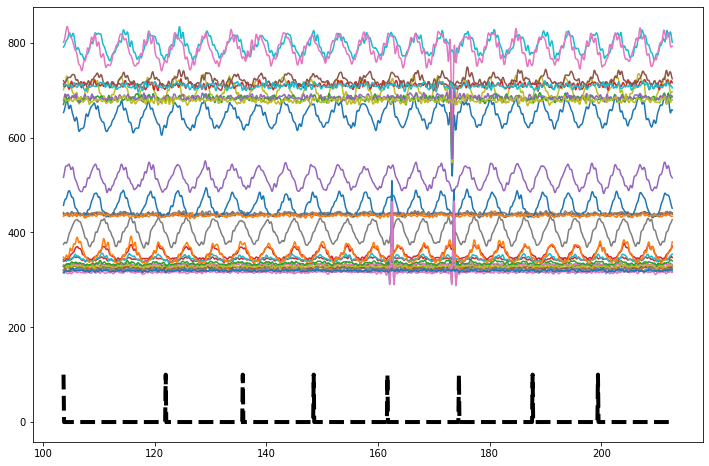

In [99]:
plt.figure(figsize=(12,8))
plt.plot(timings, brain)
plt.plot(timings, on_off*100, ls='--', c='k', lw=4)
plt.show()

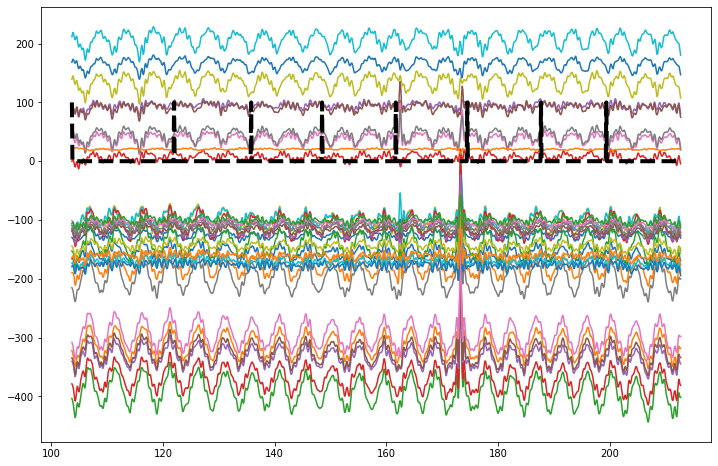

In [100]:
# band pass (.05 hz to 2 hz)
fs = 10  # Sampling frequency, in Hz

# Design filter
b_low, a_low = butter(4, 0.05 / (0.5 * fs), btype='high')
b_high, a_high = butter(4, 2 / (0.5 * fs), btype='low')

# Apply filters
y_high = filtfilt(b_low, a_low, brain)
brain = filtfilt(b_high, a_high, y_high)

plt.figure(figsize=(12,8))
plt.plot(timings, brain)
plt.plot(timings, on_off*100, ls='--', c='k', lw=4)
plt.show()

In [101]:
S_FREQ = 5 # sampling frequency in Hz

dod = ns.intensities_to_od_changes(intensities)
print("Delta OD shape: {}".format(dod.shape))

channels = data['SD']['MeasList'][0, 0][:, :2].tolist()
raw_ch_names = [str(ch).replace('[', '').replace(']', '').replace(', ', '-')
                for ch in channels]
print("Channel names: {}".format(raw_ch_names))

wavelengths = data['SD']['Lambda'][0, 0][0].tolist()
ch_high_wl = [wavelengths[0] for _ in range(int(len(raw_ch_names)/2))]
ch_low_wl = [wavelengths[1] for _ in range(int(len(raw_ch_names)/2))]
ch_low_wl += 15 # change 735 to 750
ch_wl = ch_high_wl + ch_low_wl
print("Channel wavelengths: {}".format(ch_wl))

unique_dpf = 6
ch_dpf = [unique_dpf for _ in enumerate(raw_ch_names)]
print("Channel DPFs: {}".format(ch_dpf))

# unique_distance = 3  # cm
ch_distances = [4, 3, 3, 6, 6, 4, 3, 3, 3, 3, 4, 6, 6, 4, 3, 3, 3, 3, 4, 6, 6, 4, 3, 3, 3, 3, 4, 6, 6, 4, 3, 3]
print("Channel distances: {}".format(ch_distances))

Delta OD shape: (32, 1091)
Channel names: ['1.0-1.0', '1.0-2.0', '1.0-3.0', '1.0-4.0', '2.0-1.0', '2.0-2.0', '2.0-3.0', '2.0-4.0', '3.0-5.0', '3.0-6.0', '3.0-7.0', '3.0-8.0', '4.0-5.0', '4.0-6.0', '4.0-7.0', '4.0-8.0', '1.0-1.0', '1.0-2.0', '1.0-3.0', '1.0-4.0', '2.0-1.0', '2.0-2.0', '2.0-3.0', '2.0-4.0', '3.0-5.0', '3.0-6.0', '3.0-7.0', '3.0-8.0', '4.0-5.0', '4.0-6.0', '4.0-7.0', '4.0-8.0']
Channel wavelengths: [735.0, 735.0, 735.0, 735.0, 735.0, 735.0, 735.0, 735.0, 735.0, 735.0, 735.0, 735.0, 735.0, 735.0, 735.0, 735.0, 850.0, 850.0, 850.0, 850.0, 850.0, 850.0, 850.0, 850.0, 850.0, 850.0, 850.0, 850.0, 850.0, 850.0, 850.0, 850.0]
Channel DPFs: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Channel distances: [3, 3, 4, 6, 6, 4, 3, 3, 3, 3, 4, 6, 6, 4, 3, 3, 3, 3, 4, 6, 6, 4, 3, 3, 3, 3, 4, 6, 6, 4, 3, 3]


In [102]:
data = ns.mbll(dod, raw_ch_names, ch_wl, ch_dpf, ch_distances, unit='cm', table='wray')
dc, ch_names, ch_types = data

In [103]:
data = ns.cbsi(dc, ch_names, ch_types)
dc_0, ch_names_0, ch_types_0 = data
print("Delta HbO_0 and HbR_0 shape: {}".format(dc_0.shape))
print(ch_names_0)

Delta HbO_0 and HbR_0 shape: (32, 1091)
['1.0-1.0', '1.0-1.0', '1.0-2.0', '1.0-2.0', '1.0-3.0', '1.0-3.0', '1.0-4.0', '1.0-4.0', '2.0-1.0', '2.0-1.0', '2.0-2.0', '2.0-2.0', '2.0-3.0', '2.0-3.0', '2.0-4.0', '2.0-4.0', '3.0-5.0', '3.0-5.0', '3.0-6.0', '3.0-6.0', '3.0-7.0', '3.0-7.0', '3.0-8.0', '3.0-8.0', '4.0-5.0', '4.0-5.0', '4.0-6.0', '4.0-6.0', '4.0-7.0', '4.0-7.0', '4.0-8.0', '4.0-8.0']


MNE channel names: ['1.0-1.0 hbo', '1.0-1.0 hbr', '1.0-2.0 hbo', '1.0-2.0 hbr', '1.0-3.0 hbo', '1.0-3.0 hbr', '1.0-4.0 hbo', '1.0-4.0 hbr', '2.0-1.0 hbo', '2.0-1.0 hbr', '2.0-2.0 hbo', '2.0-2.0 hbr', '2.0-3.0 hbo', '2.0-3.0 hbr', '2.0-4.0 hbo', '2.0-4.0 hbr', '3.0-5.0 hbo', '3.0-5.0 hbr', '3.0-6.0 hbo', '3.0-6.0 hbr', '3.0-7.0 hbo', '3.0-7.0 hbr', '3.0-8.0 hbo', '3.0-8.0 hbr', '4.0-5.0 hbo', '4.0-5.0 hbr', '4.0-6.0 hbo', '4.0-6.0 hbr', '4.0-7.0 hbo', '4.0-7.0 hbr', '4.0-8.0 hbo', '4.0-8.0 hbr']
Creating RawArray with float64 data, n_channels=32, n_times=1091
    Range : 0 ... 1090 =      0.000 ...   218.000 secs
Ready.


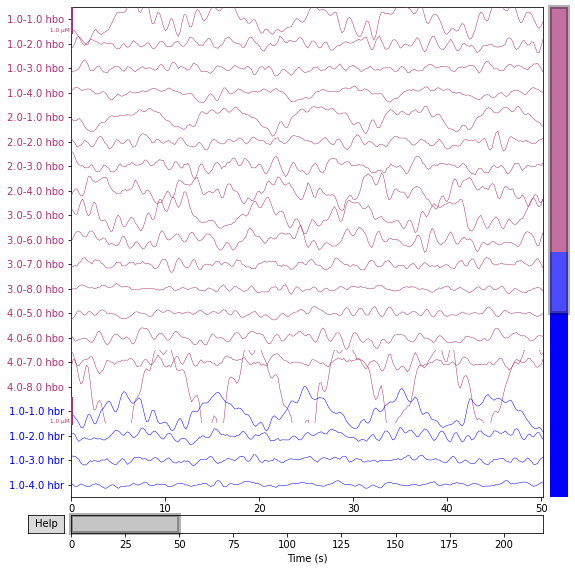

In [104]:
mne_ch_names = [ch + ' ' + ch_types[i] for i, ch in enumerate(ch_names)]
print("MNE channel names: {}".format(mne_ch_names))
info = mne.create_info(ch_names=mne_ch_names, sfreq=S_FREQ,
                       ch_types=ch_types)
raw = mne.io.RawArray(dc, info)
graph = raw.plot(scalings=0.5e-6, duration=50)

MNE channel names: ['1.0-1.0 hbo_0', '1.0-1.0 hbr_0', '1.0-2.0 hbo_0', '1.0-2.0 hbr_0', '1.0-3.0 hbo_0', '1.0-3.0 hbr_0', '1.0-4.0 hbo_0', '1.0-4.0 hbr_0', '2.0-1.0 hbo_0', '2.0-1.0 hbr_0', '2.0-2.0 hbo_0', '2.0-2.0 hbr_0', '2.0-3.0 hbo_0', '2.0-3.0 hbr_0', '2.0-4.0 hbo_0', '2.0-4.0 hbr_0', '3.0-5.0 hbo_0', '3.0-5.0 hbr_0', '3.0-6.0 hbo_0', '3.0-6.0 hbr_0', '3.0-7.0 hbo_0', '3.0-7.0 hbr_0', '3.0-8.0 hbo_0', '3.0-8.0 hbr_0', '4.0-5.0 hbo_0', '4.0-5.0 hbr_0', '4.0-6.0 hbo_0', '4.0-6.0 hbr_0', '4.0-7.0 hbo_0', '4.0-7.0 hbr_0', '4.0-8.0 hbo_0', '4.0-8.0 hbr_0']
Creating RawArray with float64 data, n_channels=32, n_times=1091
    Range : 0 ... 1090 =      0.000 ...   218.000 secs
Ready.


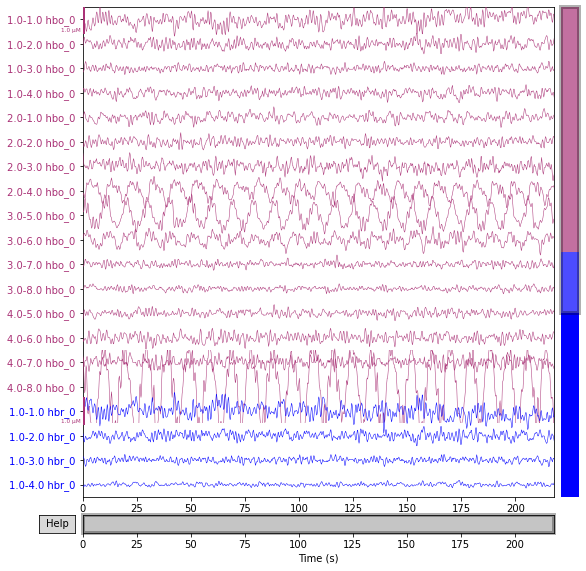

In [105]:
mne_ch_names_0 = [ch + ' ' + ch_types_0[i] + '_0'
                  for i, ch in enumerate(ch_names_0)]
print("MNE channel names: {}".format(mne_ch_names_0))
info_0 = mne.create_info(ch_names=mne_ch_names_0, sfreq=S_FREQ,
                         ch_types=ch_types_0)
raw_0 = mne.io.RawArray(dc_0, info_0)
graph_0 = raw_0.plot(scalings=0.5e-6, duration=250)

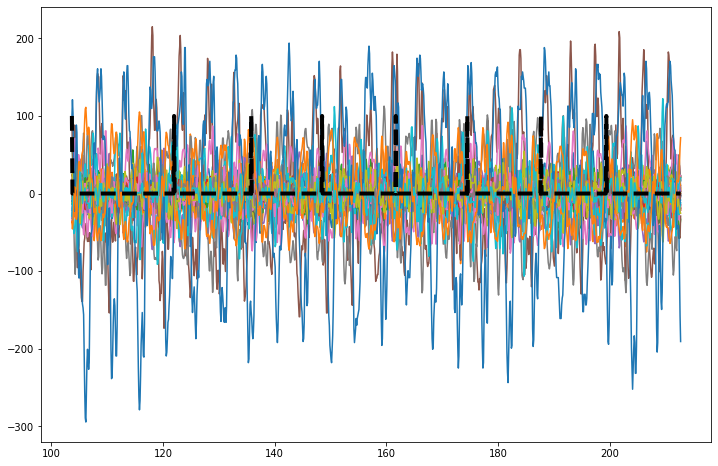

(32, 1091)
(32, 0)
(32, 0)


In [177]:
plt.figure(figsize=(12,8))
plt.plot(timings, dc_0.T * 1e8)
plt.plot(timings, on_off*100, ls='--', c='k', lw=4)
plt.show()

closed_ = dc_0[:,cond_list=="closed"]
open_ = dc_0[:,cond_list=="open"]

print(dc_0.shape)
print(closed_.shape)
print(open_.shape)

(1091, 32)


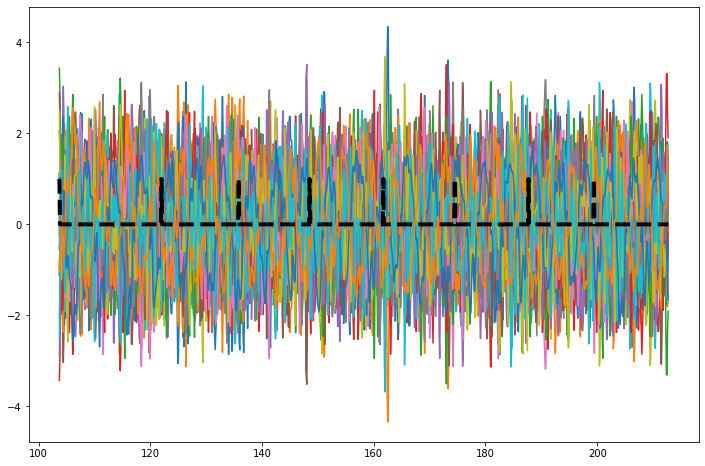

In [108]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# brain_standardized = scaler.fit_transform(dc_0.T)
# # brain_standardized = np.clip(brain_standardized, -5, 5)
# print(brain_standardized.shape)

# plt.figure(figsize=(12,8))
# plt.plot(timings, brain_standardized)
# plt.plot(timings, on_off, ls='--', c='k', lw=4)
# plt.show()

In [128]:
# Initialize a matrix to hold the power spectrum
N = dc_0.shape[1]  # Number of timepoints
freq_points = N // 2
power_matrix = np.zeros((32, freq_points))

# Loop through each channel to calculate the power spectrum
for i in range(32):
    channel_data = dc_0[i, :]
    Y = np.fft.fft(channel_data) / N
    Y = Y[0:freq_points]  # Keep only the first half
    power = np.abs(Y)**2  # Calculate power spectrum
    power_matrix[i, :] = power  # Store in the matrix

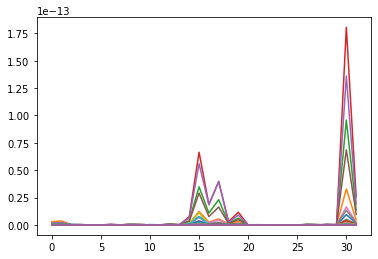

In [140]:
plt.plot(power_matrix);
plt.show()

In [136]:
# Initialize a matrix to hold the filtered time series data
filtered_time_series = np.zeros((32, N))

# Loop through each channel to apply the filter and perform IFFT
for i in range(32):
    power = power_matrix[i, :]
    Y = np.fft.fft(dc_0[i, :]) / N  # Original FFT of the channel
    freq_indices_to_keep = np.where((power >= 5) & (power <= 25))[0]  # Indices satisfying power condition
    
    # Zero out the FFT components that don't meet the power condition
    Y_filtered = np.zeros(N, dtype=complex)
    Y_filtered[0:freq_points] = Y[0:freq_points]
    Y_filtered[freq_indices_to_keep] = Y[freq_indices_to_keep]
    
    # Perform IFFT to get back to time domain
    y_filtered = np.fft.ifft(Y_filtered) * N
    filtered_time_series[i, :] = np.real(y_filtered)  # Keep only the real part

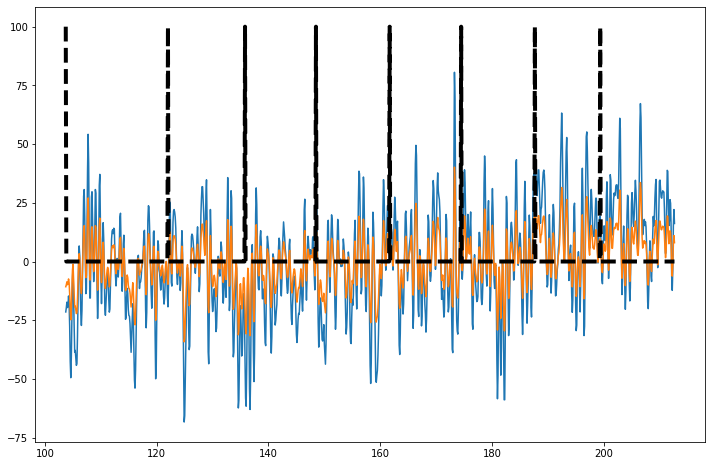

In [176]:
plt.figure(figsize=(12,8))
plt.plot(timings, dc_0.T[:,0] * 1e8)
plt.plot(timings, filtered_time_series.T[:,0] * 1e8)
plt.plot(timings, on_off*100, ls='--', c='k', lw=4)
plt.show()

In [175]:
uniq_conds = np.unique(cond_list)
print(uniq_conds)

['closed_1' 'closed_3' 'closed_5' 'closed_7' 'open_2' 'open_4' 'open_6'
 'open_8']
